In [1]:
import imports as im
import functions as fn
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
# %config InlineBackend.figure_format = 'jpg'

2023-05-24 17:33:32.963503: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
path_file = '../data/roti/2010-2020/roti'
# roti data and date
roti_map_date = []
roti_maps = []
# get date and roti maps
roti_map_date, roti_maps = fn.get_array_roti(path_file)

roti_maps_reshape = roti_maps.reshape(roti_maps.shape[0], 3600)

print("shape roti data ", roti_maps.shape)
print("shape roti data reshape", roti_maps_reshape.shape)
print("shape roti date line ", roti_map_date.shape)

shape roti data  (4469, 20, 180)
shape roti data reshape (4469, 3600)
shape roti date line  (4469, 3)


In [3]:
# get maps data
new_roti_maps = fn.roti_encode(roti_maps_reshape, 1)
# get average map for each day for training dataset
train_roti_maps = fn.roti_encode(roti_maps_reshape, 3600)

print(new_roti_maps.shape)
print(train_roti_maps.shape)

(4469, 3600)
(4469, 1)


Here is the content of training datasets with indeces

index | name
:----: | ------------
0 | avg F10-7
1 | F10-7 27-days median
2 | avg F10-7 27 days ago
3 | max scalar B
4 | max scalar B 27 days ago
5 | min BZ
6 | min BZ 27 days ago
7 | min BZ next day
8 | avg ROTI in the whole map

In [4]:
filename = "../data/imf-bz-f107-au-al/omni2_Shvf6pN7UL.lst.txt"
# get training arrays of indeces' data
data_all_arr, date_arr = fn.get_all_data(filename, train_roti_maps, roti_map_date, day_end=19, month_end=6, year_end=2022)

print(data_all_arr.shape)

(4468, 9)


In [5]:
print("ROTI date start", roti_map_date[0])
print("ROTI date end", roti_map_date[-1], "\n")

print("Indexes date start", date_arr[0])
print("Indexes date end", date_arr[-1])

ROTI date start [   1    1 2010]
ROTI date end [  19    6 2022] 

Indexes date start [   1    1 2010]
Indexes date end [  18    6 2022]


### Principal Component Analysis (PCA)

Now let's choose the number of components that we will use for further work. To do this, let's look at the ratio of variance and the number of components that explain it for all these indices

There are several reasons why dimensionality reduction is used in machine learning: to combat computational costs, to control retraining, as well as to visualize and help interpret high-dimensional datasets.

Often in machine learning, the more features there are in a dataset, the better the classifier can be trained. However, more functions also means higher computational costs. Not only can high dimensionality lead to a long learning time, a larger number of functions often leads to retooling of the algorithm as it tries to create a model that explains all the functions in the data.

Since reducing the dimensionality reduces the total number of features, this can reduce the computational requirements associated with training the model, but also helps to combat overfitting by keeping the features that will be transferred to the model fairly simple.

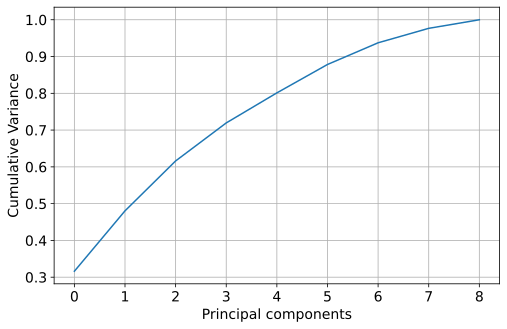

In [6]:
# Normalize data
train_num = len(data_all_arr)
all_indexes =fn.mean_data(data_all_arr, train_num=train_num)

pdf = im.PdfPages("../images/pca.pdf")

font = im.FontProperties() 
font.set_family('serif') 
font.set_name('Times New Roman') 
font.set_size(16)

scaler = im.StandardScaler()
X_features = scaler.fit_transform(all_indexes)

pca = im.PCA(n_components=all_indexes.shape[-1])
pca.fit(X_features)
pca_variance = pca.explained_variance_

var1 = im.np.cumsum(im.np.round(pca.explained_variance_ratio_, decimals=4))

fig, ax = im.plt.subplots(figsize=(8, 5))
ax.plot(var1)
ax.set_ylabel("Cumulative Variance")
ax.set_xlabel("Principal components")
im.plt.grid()
pdf.savefig(fig)
pdf.close()
im.plt.show()

Now we will use PCA to get a list of functions and plot which functions have the greatest explanatory power or have the greatest variance. These are the main components.

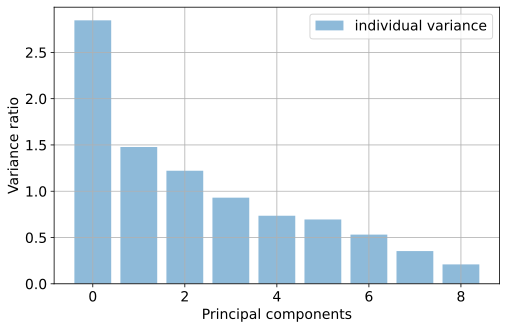

In [7]:
pdf = im.PdfPages("../images/pca_bar.pdf")
fig, ax = im.plt.subplots(figsize=(8, 5))
ax.bar(range(9), pca_variance, alpha=0.5, align='center', label='individual variance')
ax.set_ylabel("Variance ratio")
ax.set_xlabel("Principal components")
im.plt.grid()
im.plt.legend()
pdf.savefig(fig)
pdf.close()
im.plt.show()

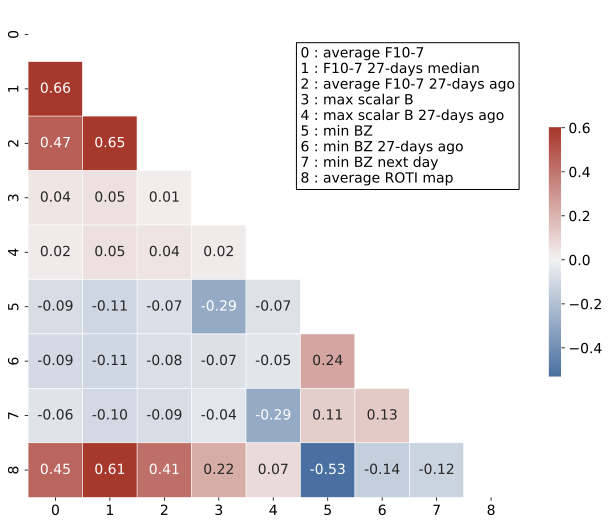

In [8]:
import seaborn as sns

df = im.pd.DataFrame(all_indexes, columns = ['0', '1', '2', '3', '4', '5', '6', '7', '8'])

# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = im.np.triu(im.np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
fig, ax = im.plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                            n=9, center="light", as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
fig = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0, annot=True, 
            fmt='.2f', square=True, linewidths=.5, cbar_kws={"shrink": .5})
text = "0 : average F10-7\n1 : F10-7 27-days median\n2 : average F10-7 27-days ago\n3 : max scalar B\n4 : max scalar B 27-days ago\n5 : min BZ\n6 : min BZ 27-days ago\n7 : min BZ next day\n8 : average ROTI map"
im.plt.text(5., 2., text, fontsize=14,
 # Vertical and horizontal alignment
 horizontalalignment='left', verticalalignment='center',
 bbox=dict(facecolor='white', alpha=1.0))

im.plt.show()

In [9]:
# https://habr.com/ru/post/495884/

train_num = 3100
all_indexes = fn.mean_data(data_all_arr, train_num=train_num)

start_index = 0
end_index = 3100
end_index_val = 3935
# end_index = 9000
history_size = 2
target_size = 1
batch_size = 24
buffer_size = 256

x_train, y_train = fn.multivariate_data(all_indexes, new_roti_maps, start_index, end_index, history_size, target_size)
x_train_test, y_train_test = fn.multivariate_data_test(all_indexes, new_roti_maps, 0, None, history_size, target_size)
# x_train, y_train = multivariate_data(big_indexes, big_roti, start_index, end_index, history_size, target_size)
# x_train = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
# x_train_test = x_train_test.reshape(x_train_test.shape[0], x_train_test.shape[1] * x_train_test.shape[2])

x_val, y_val = fn.multivariate_data(all_indexes, new_roti_maps, end_index, end_index_val, history_size, target_size)
# x_val, y_val = multivariate_data(big_indexes, big_roti, end_index, end_index_val, history_size, target_size)
# x_val = x_val.reshape(x_val.shape[0], x_val.shape[1] * x_val.shape[2])

train_data = im.tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
# train_data = train_data.batch(batch_size).repeat()

val_data = im.tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_data = val_data.batch(batch_size).repeat()

2023-05-24 17:35:58.498187: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
print(x_train.shape)
print(x_train_test.shape)
print(x_val.shape)

(3086, 2, 9)
(4465, 2, 9)
(833, 2, 9)


```
    shuffle(buffer_size, seed=None, reshuffle_each_iteration=None, name=None)
```

Randomly shuffles the elements of this dataset.

This dataset fills a buffer with buffer_size elements, then randomly samples elements from this buffer, replacing the selected elements with new elements. For perfect shuffling, a buffer size greater than or equal to the full size of the dataset is required.

For instance, if your dataset contains 10,000 elements but buffer_size is set to 1,000, then shuffle will initially select a random element from only the first 1,000 elements in the buffer. Once an element is selected, its space in the buffer is replaced by the next (i.e. 1,001-st) element, maintaining the 1,000 element buffer.

In [11]:
from keras import metrics

weights_file = 'W_NN_ts.h5'

callback = im.ModelCheckpoint(weights_file, mode='max', save_best_only=True)

classifier = im.Sequential()
classifier.add(im.layers.LSTM(10, input_shape=x_train.shape[-2:]))
classifier.add(im.Dense(512, activation='selu', kernel_initializer='random_normal'))
classifier.add(im.Dense(1024, activation='selu', kernel_initializer='random_normal'))
# classifier.add(Dense(812, activation='relu', kernel_initializer='random_normal'))
classifier.add(im.Dense(2048, activation='selu', kernel_initializer='random_normal'))
classifier.add(im.Dense(new_roti_maps.shape[-1], activation='sigmoid', kernel_initializer='random_normal'))

classifier.compile(optimizer='adam', loss=im.tf.keras.losses.Huber(delta=2.15), metrics=['accuracy'])

classifier.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                800       
                                                                 
 dense (Dense)               (None, 512)               5632      
                                                                 
 dense_1 (Dense)             (None, 1024)              525312    
                                                                 
 dense_2 (Dense)             (None, 2048)              2099200   
                                                                 
 dense_3 (Dense)             (None, 3600)              7376400   
                                                                 
Total params: 10,007,344
Trainable params: 10,007,344
Non-trainable params: 0
_________________________________________________________________


In [12]:
epochs = 5

history = classifier.fit(
    train_data,
    epochs=epochs,
    steps_per_epoch=x_train.shape[0] // batch_size,
    validation_data=val_data,
    validation_steps=x_val.shape[0] // batch_size,
    callbacks=[callback])

json_file = 'M_NN_ts.json'
model_json = classifier.to_json()
with open(json_file, 'w') as f:
    f.write(model_json)

Epoch 1/5
128/128 [==============================] - 7s 42ms/step - loss: 0.0128 - accuracy: 0.0085 - val_loss: 0.0027 - val_accuracy: 0.0074
Epoch 2/5
128/128 [==============================] - 5s 38ms/step - loss: 0.0082 - accuracy: 0.0085 - val_loss: 0.0025 - val_accuracy: 0.0086
Epoch 3/5
128/128 [==============================] - 5s 39ms/step - loss: 0.0079 - accuracy: 0.0075 - val_loss: 0.0024 - val_accuracy: 0.0184
Epoch 4/5
128/128 [==============================] - 5s 39ms/step - loss: 0.0077 - accuracy: 0.0078 - val_loss: 0.0025 - val_accuracy: 0.0049
Epoch 5/5
128/128 [==============================] - 5s 39ms/step - loss: 0.0077 - accuracy: 0.0065 - val_loss: 0.0024 - val_accuracy: 0.0049


In [15]:
# for loaded models
# model_file = 'M_NN_ts.json'
# weights_file = 'W_NN_ts.h5'
# with open(model_file, 'r') as f:
#   loaded_model = model_from_json(f.read())
   
# classifier.load_weights(weights_file)

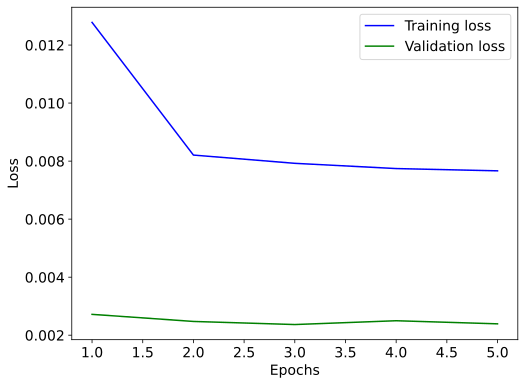

In [13]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

fn.PlotLossAcc(loss, val_loss, epochs, TrainLabel='Training loss', ValLabel='Validation loss',
               yLabel="Loss", filename="../images/loss.pdf")

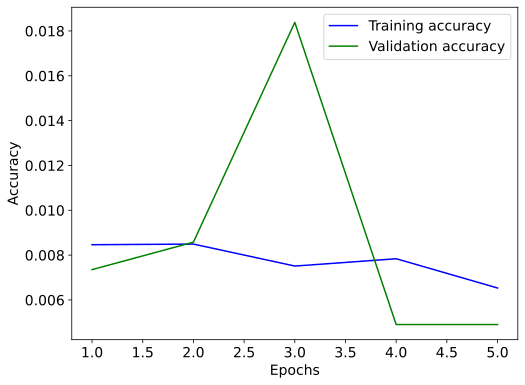

In [14]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(loss) + 1)

fn.PlotLossAcc(accuracy, val_accuracy, epochs, TrainLabel='Training accuracy', ValLabel='Validation accuracy',
               yLabel="Accuracy", filename="../images/acc.pdf")

1/1 [==============================] - 0s 330ms/step


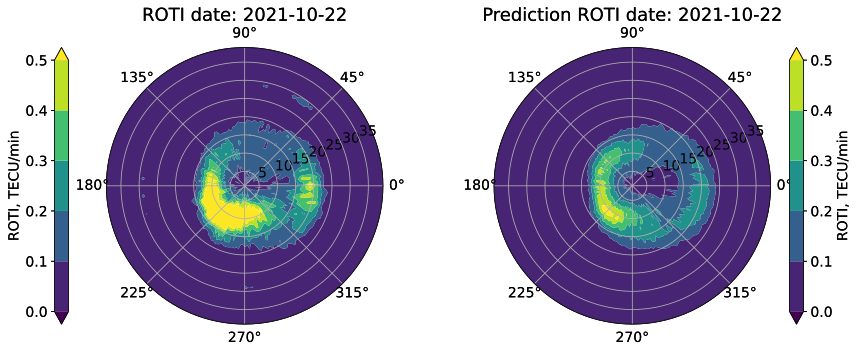

In [15]:
pdf_file = "../images/nonchalant_result.pdf"
# start = 1996
start = 4226
end = start + 1

y_pred=classifier.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file=pdf_file, WriteFile=True)

1/1 [==============================] - 0s 17ms/step


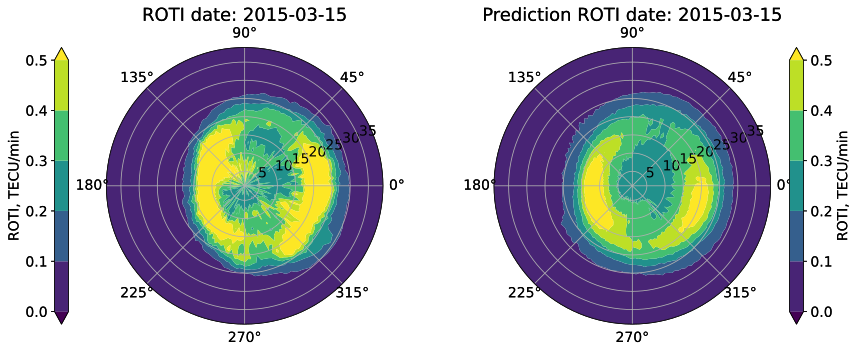

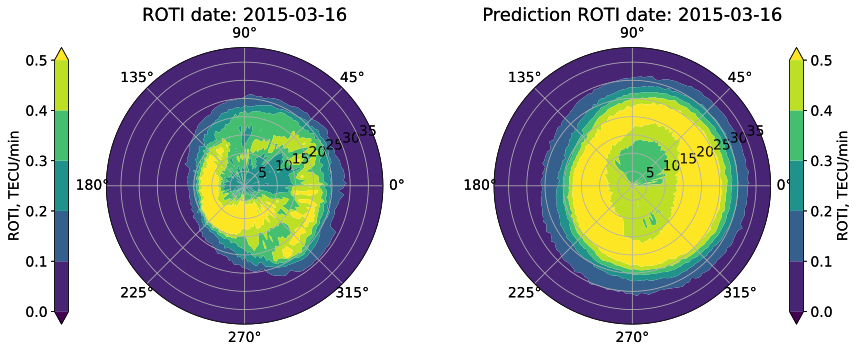

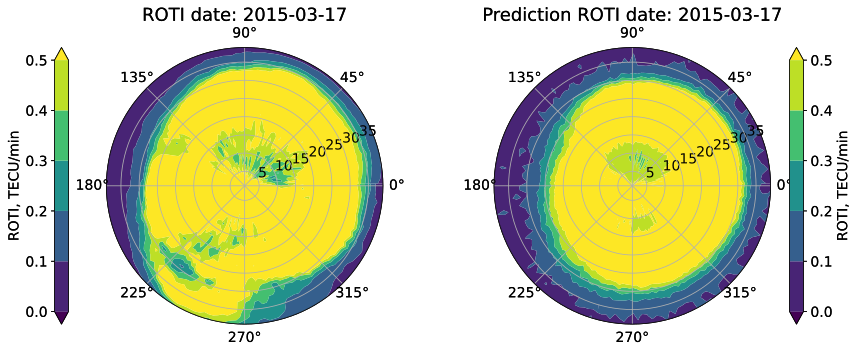

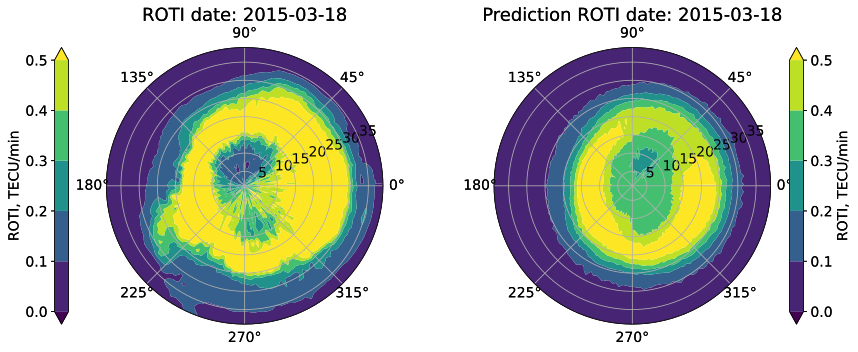

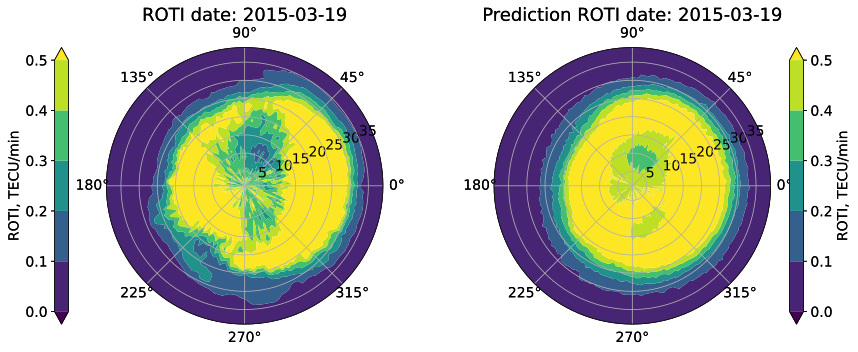

In [16]:
start = 1897
end = 1902

y_pred=classifier.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)

1/1 [==============================] - 0s 18ms/step


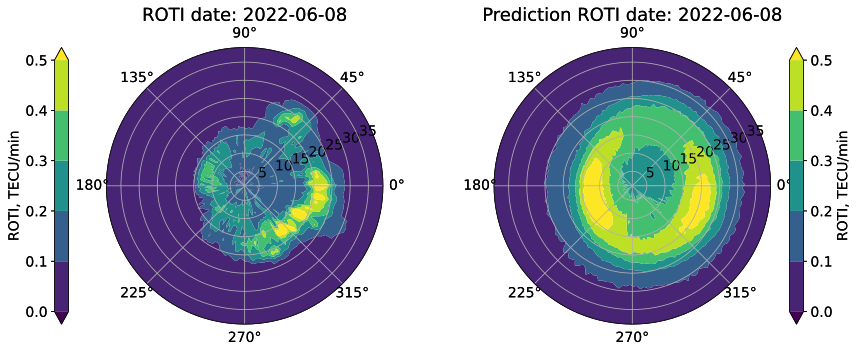

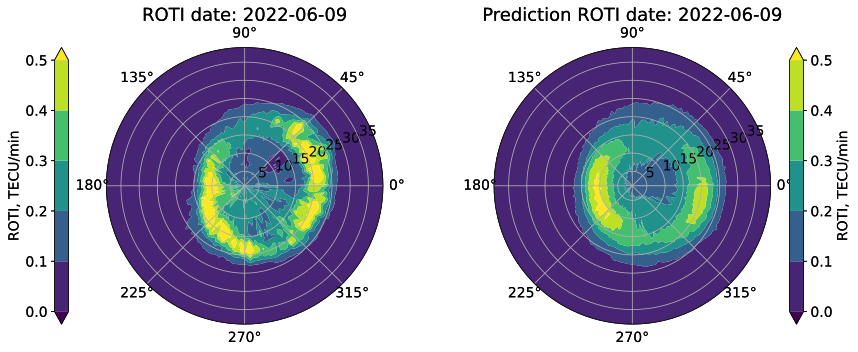

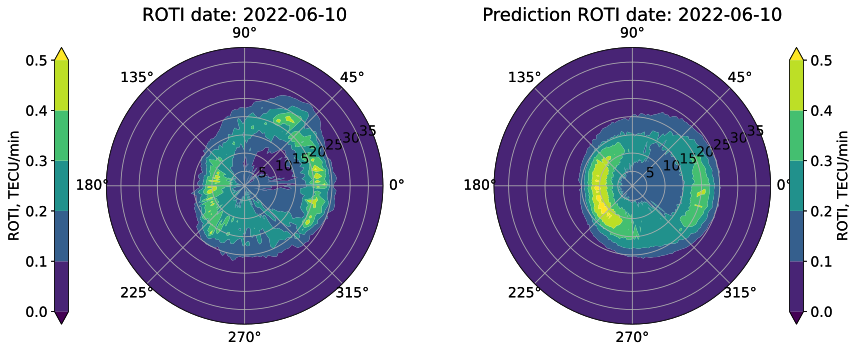

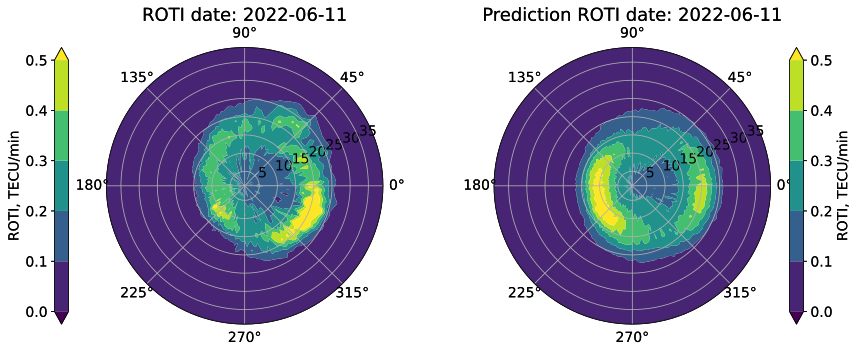

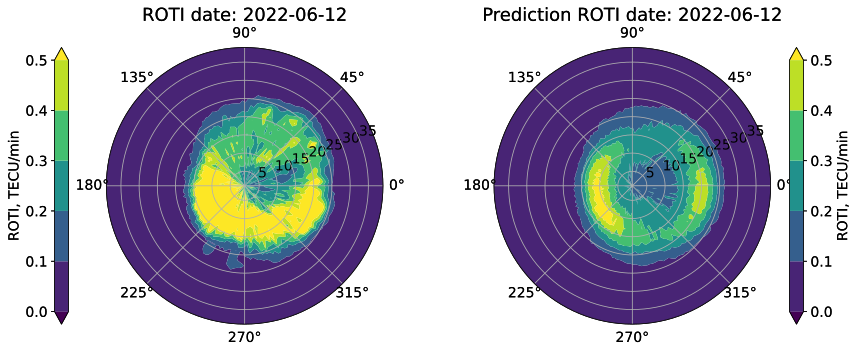

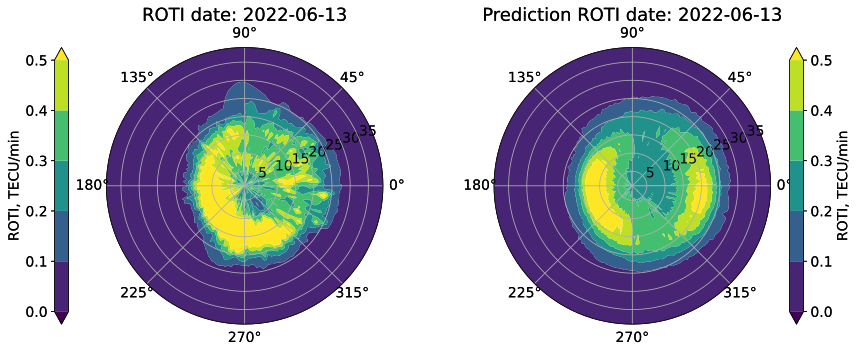

In [18]:
start = 1994
end = 2001

# start = 4455
# end = 4461

y_pred=classifier.predict(x_train_test[start:end])

fn.PlotRotiPredictions(start, end, y_pred, x_train_test, roti_map_date, pdf_file="", WriteFile=False)